In [2]:
# Import libraries
import numpy as np
import pandas as pd
import yfinance as yf
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
pd.set_option('display.max_columns', 100)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

# Ticker list and parameters
tickers = [
    'AAPL', 'MSFT', 'NVDA', 'AMZN', 'GOOGL',
    'META', 'TSLA', 'BRK-B', 'JPM', 'V',
    'SAP.DE', 'SIE.DE', 'ALV.DE', 'VOW3.DE', 'LIN.DE',
    'MC.PA', 'OR.PA', 'AIR.PA', 'ASML.AS', 'NESN.SW'
]
start_date = '2010-01-01'
end_date = '2025-03-31'
group_by = 'ticker'

In [4]:
def download_stock_data(tickers, start_date, end_date):
    """Download international stock data with progress tracking"""
    print(f"Downloading {len(tickers)} stocks...")
    data = yf.download(
        tickers=tickers,
        start=start_date,
        end=end_date,
        group_by=group_by,
        auto_adjust=True,
        progress=True
    )
    print("\nDownload completed!")
    return data

In [6]:
# Execute download
raw_data = download_stock_data(tickers, start_date, end_date)

# Check available tickers
available_tickers = [ticker for ticker in tickers if ticker in raw_data]
print(f"\nSuccessfully downloaded {len(available_tickers)}/{len(tickers)} tickers")
print("Missing tickers:", set(tickers) - set(available_tickers))

[*********************100%***********************]  20 of 20 completed


Download completed!

Successfully downloaded 20/20 tickers
Missing tickers: set()


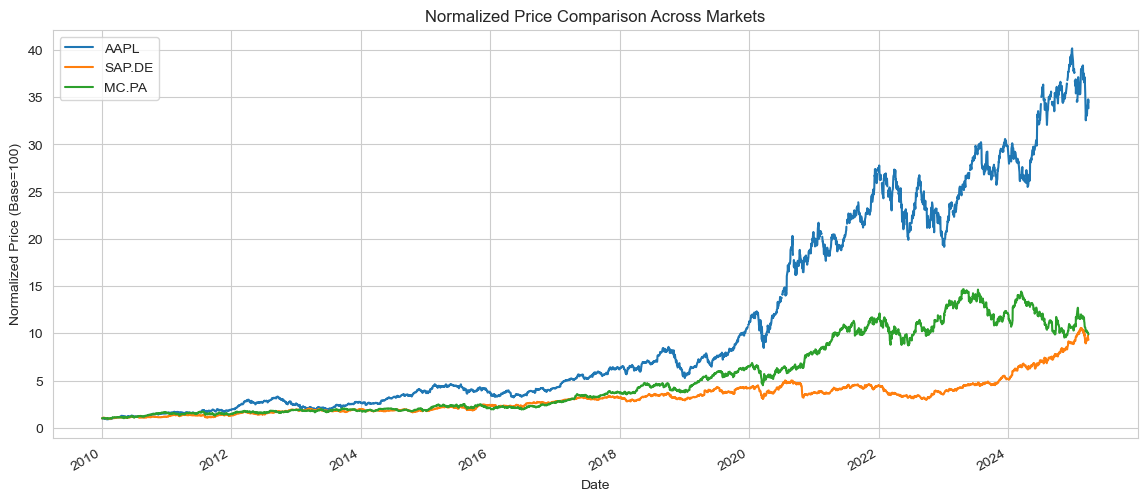

In [8]:
# Plot normalized prices for different markets
plt.figure(figsize=(14, 6))
sample_tickers = ['AAPL', 'SAP.DE', 'MC.PA']  # US, Germany, France
for ticker in sample_tickers:
    if ticker in raw_data:
        (raw_data[ticker]['Close'] / raw_data[ticker]['Close'].iloc[0]).plot(label=ticker)
plt.title('Normalized Price Comparison Across Markets')
plt.ylabel('Normalized Price (Base=100)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
def preprocess_stock_data(data, tickers, lookback=5):
    """Clean and prepare stock data with international support"""
    processed_data = {}
    
    for ticker in tickers:
        if ticker in data:
            df = data[ticker].copy()
            
            # Handle datetime index
            if isinstance(df.index, pd.DatetimeIndex):
                df.index = df.index.tz_localize(None)
            
            # Core features
            df['Return'] = df['Close'].pct_change()
            df['Volatility'] = df['Return'].rolling(21).std()
            df['Dollar_Volume'] = df['Volume'] * df['Close']
            
            # Lag features
            for lag in range(1, lookback + 1):
                df[f'Return_lag_{lag}'] = df['Return'].shift(lag)
            
            # Target: 5-day future return
            df['Target'] = df['Close'].pct_change(5).shift(-5)
            
            df = df.dropna()
            
            if len(df) > 100:  # Minimum data requirement
                processed_data[ticker] = df
            else:
                print(f"Skipped {ticker} (only {len(df)} valid rows)")
    
    return processed_data

In [12]:
processed_data = preprocess_stock_data(raw_data, available_tickers)
print(f"\nPreprocessed data for {len(processed_data)} tickers")

C:\Users\joelt\AppData\Local\Temp\ipykernel_69388\756517496.py:14: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Return'] = df['Close'].pct_change()
C:\Users\joelt\AppData\Local\Temp\ipykernel_69388\756517496.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Target'] = df['Close'].pct_change(5).shift(-5)
C:\Users\joelt\AppData\Local\Temp\ipykernel_69388\756517496.py:14: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None


Preprocessed data for 20 tickers


C:\Users\joelt\AppData\Local\Temp\ipykernel_69388\756517496.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Target'] = df['Close'].pct_change(5).shift(-5)
C:\Users\joelt\AppData\Local\Temp\ipykernel_69388\756517496.py:14: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Return'] = df['Close'].pct_change()
C:\Users\joelt\AppData\Local\Temp\ipykernel_69388\756517496.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None

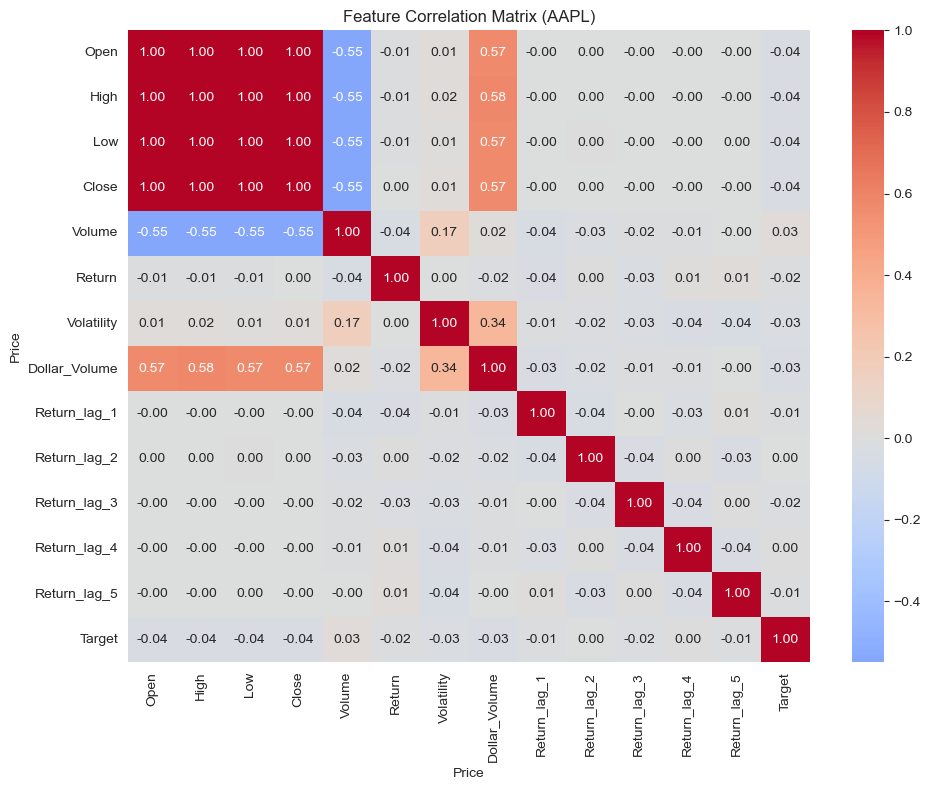

In [14]:
# Plot correlation matrix for a sample stock
sample_ticker = 'AAPL'
if sample_ticker in processed_data:
    corr_matrix = processed_data[sample_ticker].corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", center=0, cmap='coolwarm')
    plt.title(f'Feature Correlation Matrix ({sample_ticker})')
    plt.tight_layout()
    plt.show()

In [16]:
def train_stock_models(processed_data, n_splits=3):
    """Train models with time-series cross validation"""
    models = {}
    metrics = []
    
    for ticker, df in processed_data.items():
        print(f"\nTraining {ticker}...")
        
        # Prepare features
        features = [col for col in df.columns 
                   if col.startswith(('Return', 'Volatility', 'Dollar')) 
                   and 'lag' not in col]
        X = df[features]
        y = df['Target']
        
        # Time-series CV
        tscv = TimeSeriesSplit(n_splits=n_splits)
        fold_scores = []
        
        for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            # Scale features
            scaler = RobustScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # Initialize and train model
            model = CatBoostRegressor(
                iterations=500,
                learning_rate=0.05,
                depth=6,
                silent=True
            )
            model.fit(X_train_scaled, y_train)
            
            # Evaluate
            preds = model.predict(X_test_scaled)
            rmse = np.sqrt(mean_squared_error(y_test, preds))
            fold_scores.append(rmse)
            
        # Store the final model
        models[ticker] = {
            'model': model,
            'scaler': scaler,
            'features': features,
            'avg_rmse': np.mean(fold_scores)
        }
        
        metrics.append({
            'Ticker': ticker,
            'Avg_RMSE': np.mean(fold_scores),
            'Best_Fold': np.min(fold_scores)
        })
    
    return models, pd.DataFrame(metrics)

In [18]:
trained_models, model_metrics = train_stock_models(processed_data)

# Display performance metrics
print("\nModel Performance Summary:")
display(model_metrics.sort_values('Avg_RMSE'))


Training AAPL...

Training MSFT...

Training NVDA...

Training AMZN...

Training GOOGL...

Training META...

Training TSLA...

Training BRK-B...

Training JPM...

Training V...

Training SAP.DE...

Training SIE.DE...

Training ALV.DE...

Training VOW3.DE...

Training LIN.DE...

Training MC.PA...

Training OR.PA...

Training AIR.PA...

Training ASML.AS...

Training NESN.SW...

Model Performance Summary:


,Ticker,Avg_RMSE,Best_Fold
19,NESN.SW,0.022958,0.021855
7,BRK-B,0.025883,0.019665
16,OR.PA,0.030270,0.028321
9,V,0.031972,0.029545
10,SAP.DE,0.034541,0.029320
12,ALV.DE,0.034702,0.029614
1,MSFT,0.034907,0.032718
14,LIN.DE,0.035734,0.005204
8,JPM,0.037023,0.030558
11,SIE.DE,0.038176,0.033176


C:\Users\joelt\AppData\Local\Temp\ipykernel_69388\283681444.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=model_metrics.sort_values('Avg_RMSE'),


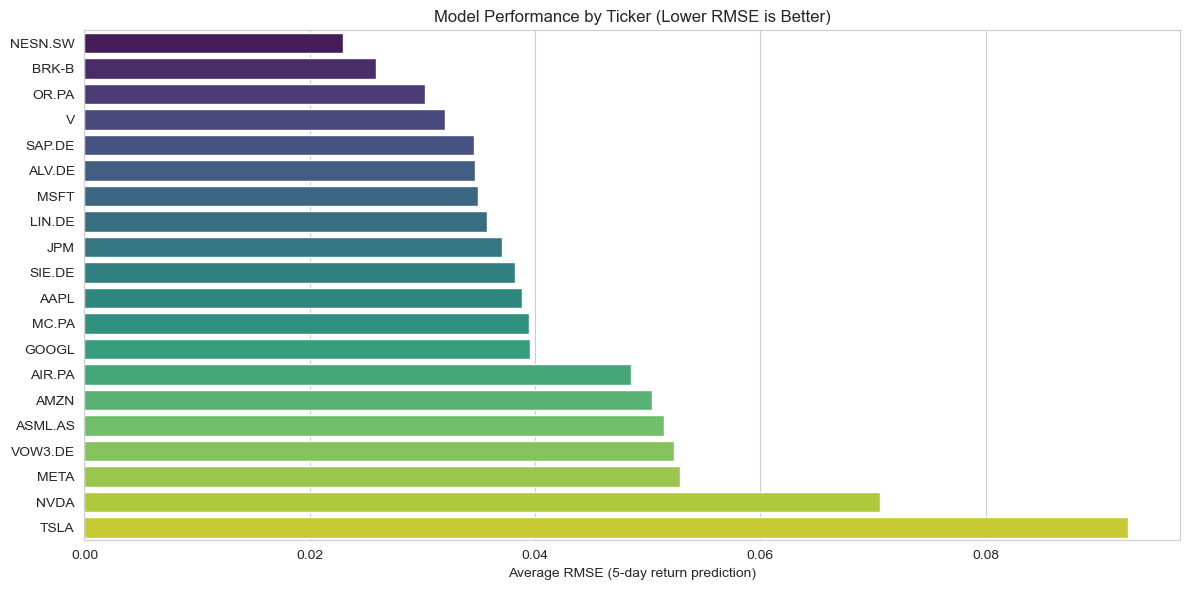

In [20]:
# Plot model performance
plt.figure(figsize=(12, 6))
sns.barplot(data=model_metrics.sort_values('Avg_RMSE'), 
            x='Avg_RMSE', y='Ticker', palette='viridis')
plt.title('Model Performance by Ticker (Lower RMSE is Better)')
plt.xlabel('Average RMSE (5-day return prediction)')
plt.ylabel('')
plt.tight_layout()
plt.show()

C:\Users\joelt\AppData\Local\Temp\ipykernel_69388\3238132922.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=fi_df, palette='Blues_d')


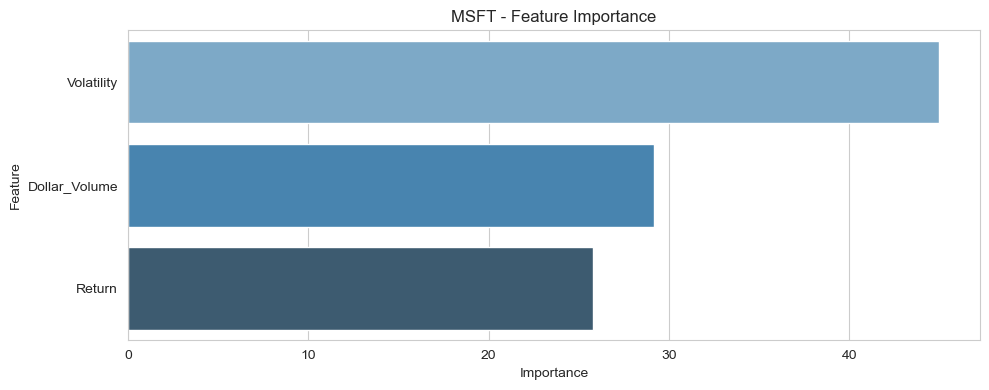

In [22]:
# Plot feature importance for a sample model
sample_ticker = 'MSFT'
if sample_ticker in trained_models:
    model = trained_models[sample_ticker]['model']
    features = trained_models[sample_ticker]['features']
    
    importance = model.get_feature_importance()
    fi_df = pd.DataFrame({'Feature': features, 'Importance': importance})
    fi_df = fi_df.sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 4))
    sns.barplot(x='Importance', y='Feature', data=fi_df, palette='Blues_d')
    plt.title(f'{sample_ticker} - Feature Importance')
    plt.tight_layout()
    plt.show()

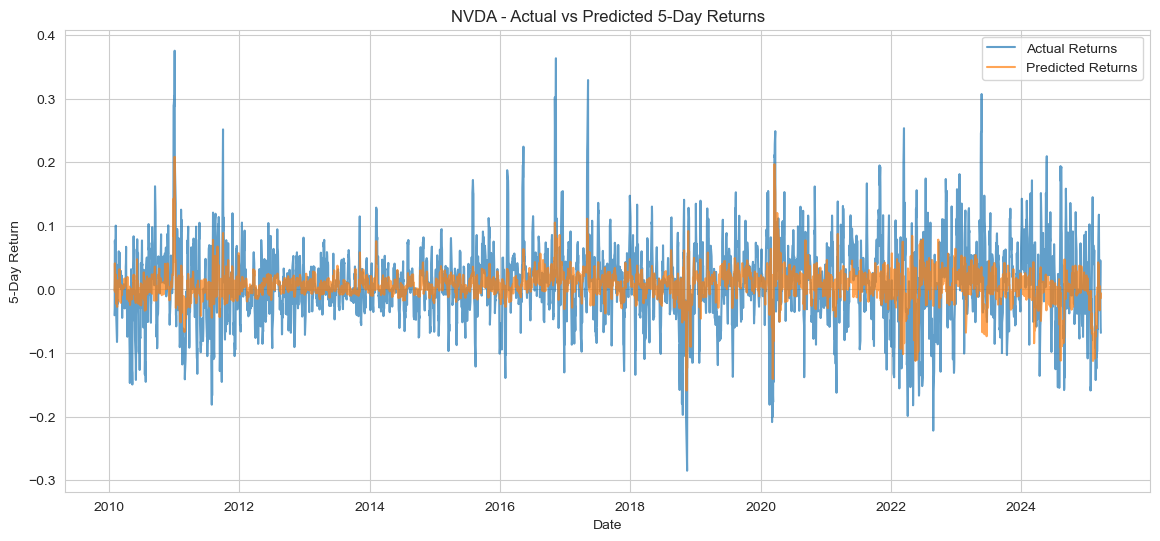

In [24]:
# Visualize predictions vs actual for a sample stock
sample_ticker = 'NVDA'
if sample_ticker in trained_models and sample_ticker in processed_data:
    model_info = trained_models[sample_ticker]
    df = processed_data[sample_ticker]
    
    X = df[model_info['features']]
    X_scaled = model_info['scaler'].transform(X)
    predictions = model_info['model'].predict(X_scaled)
    
    plt.figure(figsize=(14, 6))
    plt.plot(df.index, df['Target'], label='Actual Returns', alpha=0.7)
    plt.plot(df.index, predictions, label='Predicted Returns', alpha=0.7)
    plt.title(f'{sample_ticker} - Actual vs Predicted 5-Day Returns')
    plt.ylabel('5-Day Return')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.show()